#Parte II - Machine Learning Baseline

Vamos a construir un modelo muy sencillo para saber qué es lo peor que podemos hacer, en general esta es una tarea muy importante que queremos que repitan en sus proyectos de machine learning.

Utilice todas las columnas del dataset (exceptuando columnas que no tenga sentido usar para predecir) con algún encoding donde sea necesario para entrenar una regresión logística, utilizando búsqueda de hiperparametros y garantizando la reproducibilidad de los resultados cuando el notebook corriera varias veces. Conteste las preguntas:

* ¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el 
dataset para validar?)
* Al predecir con este modelo para test, ¿Cúal es el score obtenido? (guardar el csv con predicciones para entregarlo después)
* ¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.

In [ ]:
import pandas as pd

import random

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import top_k_accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from nltk import word_tokenize
import nltk
nltk.download('punkt')

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
test_set = pd.read_parquet("/content/drive/MyDrive/Organización de Datos/TP3/Music dataset/test.parquet")
train_set = pd.read_parquet("/content/drive/MyDrive/Organización de Datos/TP3/Music dataset/train.parquet")

### Split train y validation

In [21]:
#Hago el split de train y validation por los artistas, con una semilla para hacerlo reproducible.
#El 80% de los artistas va a train y el 20% restante a validation.
#De esta manera, se evalúa al modelo sobre artistas distintos.

artistas = train_set["artist"].unique().tolist()
random.seed(237)
random.shuffle(artistas)
artistas_20 = artistas[:2*(len(artistas)//10)]

validation = train_set[train_set["artist"].isin(artistas_20)]
train = train_set[~train_set["artist"].isin(artistas_20)]

### Separo en x_train e y_train, x_validation e y_validation

In [22]:
#Dropeo las columnas track_name, genre, artist, a_genres, did (leekean el target o no tienen sentido para predecir)

x_test = test_set[['lyric', 'language', 'popularity', 'a_songs', 'a_popularity', 's-label', 'acousticness', 'danceability', 'duration_ms',
                 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]
y_test = test_set["genre"]

x_train = train[['lyric', 'language', 'popularity', 'a_songs', 'a_popularity', 's-label', 'acousticness', 'danceability', 'duration_ms',
                 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]
y_train = train["genre"]

x_validation = validation[['genre', 'lyric', 'language', 'popularity', 'a_songs', 'a_popularity', 's-label', 'acousticness', 'danceability', 'duration_ms',
                 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]
y_validation = validation["genre"]


#Saco los géneros de validation que no están en train (no se pueden predecir cosas para las que no se entrena)

generos = y_train.unique().tolist()
x_validation = x_validation[x_validation["genre"].isin(generos)]
y_validation = y_validation[y_validation.isin(generos)]
x_validation.drop(["genre"], axis=1, inplace=True)

### Imputo valores NaN de algunas columnas

In [ ]:
#OK: popularity, a_songs, a_popularity, acousticness, danceability, duration_ms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence

#Relleno los lyrics que faltan con un string vacío
x_train["lyric"].fillna("", inplace=True)
x_test["lyric"].fillna("", inplace=True)
x_validation["lyric"].fillna("", inplace=True)

#Relleno los idiomas con el idioma más común (inglés)
language_mas_comun = x_train["language"].value_counts().idxmax()
x_train["language"].fillna(language_mas_comun, inplace=True)
x_test["language"].fillna(language_mas_comun, inplace=True)
x_validation["language"].fillna(language_mas_comun, inplace=True)

#Relleno s-label con el valor promedio
s_label_promedio = x_train["s-label"].mean()
x_train["s-label"].fillna(s_label_promedio, inplace=True)
x_test["s-label"].fillna(s_label_promedio, inplace=True)
x_validation["s-label"].fillna(s_label_promedio, inplace=True)

### Encoding

In [24]:
#Variables a encodear: lyric (NLP), language (13), key (12), mode (2), time_signature (4)

#One Hot Encoding para language, key, mode y time_signature

x_train = x_train.reset_index().drop(["index"], axis=1)
x_validation = x_validation.reset_index().drop(["index"], axis=1)
x_test = x_test.reset_index().drop(["index"], axis=1)

def one_hot_encoding(x_train, x_validation, x_test, feature, **kwargs):
  one_hot_encoder = OneHotEncoder(**kwargs)
  
  encoded_feature_train = pd.DataFrame(one_hot_encoder.fit_transform(x_train[[feature]]).todense().astype(int))
  encoded_feature_valid = pd.DataFrame(one_hot_encoder.transform(x_validation[[feature]]).todense().astype(int))
  encoded_feature_test = pd.DataFrame(one_hot_encoder.transform(x_test[[feature]]).todense().astype(int))
  
  nombres_columnas = one_hot_encoder.get_feature_names_out()
  encoded_feature_train.columns = nombres_columnas
  encoded_feature_valid.columns = nombres_columnas
  encoded_feature_test.columns = nombres_columnas
  
  x_train = x_train.drop([feature], axis=1).join(pd.DataFrame(encoded_feature_train))
  x_validation = x_validation.drop([feature], axis=1).join(pd.DataFrame(encoded_feature_valid))
  x_test = x_test.drop([feature], axis=1).join(pd.DataFrame(encoded_feature_test))
  
  return x_train, x_validation, x_test

x_train, x_validation, x_test = one_hot_encoding(x_train, x_validation, x_test, "language")
x_train, x_validation, x_test = one_hot_encoding(x_train, x_validation, x_test, "key")
x_train, x_validation, x_test = one_hot_encoding(x_train, x_validation, x_test, "mode", drop="first")
x_train, x_validation, x_test = one_hot_encoding(x_train, x_validation, x_test, "time_signature")

In [25]:
#Encoding con NLP para lyric

x_train["lyric_largo"] = x_train["lyric"].apply(lambda x: len(x))
x_validation["lyric_largo"] = x_validation["lyric"].apply(lambda x: len(x))
x_test["lyric_largo"] = x_test["lyric"].apply(lambda x: len(x))

x_train["lyric_cant_tokens"] = x_train["lyric"].apply(lambda x: len(word_tokenize(x)))
x_validation["lyric_cant_tokens"] = x_validation["lyric"].apply(lambda x: len(word_tokenize(x)))
x_test["lyric_cant_tokens"] = x_test["lyric"].apply(lambda x: len(word_tokenize(x)))

#Dropeo la columna lyric una vez obtenidas las features

x_train.drop(["lyric"], axis=1, inplace=True)
x_validation.drop(["lyric"], axis=1, inplace=True)
x_test.drop(["lyric"], axis=1, inplace=True)

### Normalización de los datos

In [26]:
scaler = MinMaxScaler()

x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_validation = pd.DataFrame(scaler.transform(x_validation))
x_test = pd.DataFrame(scaler.transform(x_test))

nombres_columnas = scaler.get_feature_names_out()
x_train.columns = nombres_columnas
x_validation.columns = nombres_columnas
x_test.columns = nombres_columnas

### Entrenamiento de un modelo de regresión logística con hiperparámetros default:

In [28]:
modelo = LogisticRegression(random_state=237)

modelo.fit(x_train, y_train)

proba_preds = modelo.predict_proba(x_validation)

top_k_accuracy_score(y_validation, proba_preds, k=2, labels=modelo.classes_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.538132911392405

### Búsqueda de hiperparámetros con Random Search:

In [29]:
modelo = LogisticRegression(random_state=237)

hiperparams = {"penalty": ["l1", "l2", "elasticnet", "none"], "dual": [True, False], "tol": [0.00001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1], "C": [0.1, 0.25, 0.5, 0.75, 1, 1.5 , 2, 5], 
              "fit_intercept": [True, False], "intercept_scaling": [0.01, 0.1, 0.25, 0.5, 0.75, 1, 1.5 , 2, 5], "class_weight": ["balanced", None], "solver": ["newton-cg", "lbfgs", "liblinear"],
              "multi_class": ["auto", "ovr", "multinomial"]}
random_search = RandomizedSearchCV(modelo, hiperparams, n_iter=100, random_state=237)
search = random_search.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python

In [30]:
search.best_params_

{'tol': 1,
 'solver': 'newton-cg',
 'penalty': 'none',
 'multi_class': 'auto',
 'intercept_scaling': 1,
 'fit_intercept': False,
 'dual': False,
 'class_weight': None,
 'C': 0.5}

Predicciones para valid con el nuevo modelo con los hiperparámetros encontrados:

In [31]:
modelo_mejorado = search.best_estimator_
proba_preds = modelo_mejorado.predict_proba(x_validation)
top_k_accuracy_score(y_validation, proba_preds, k=2, labels=modelo_mejorado.classes_)

0.5501582278481013

### Refino la búsqueda de hiperparámetros:

In [32]:
modelo = LogisticRegression(random_state=237)

hiperparams = {"penalty": ["l1", "none"], "dual": [False], "tol": [0.0001, 0.01, 0.5, 0.75, 1, 1.25], "C": [0.25, 0.40, 0.50, 0.60, 0.75, 1], 
              "fit_intercept": [True], "intercept_scaling": [0.75, 0.85, 1, 1.15, 1.25], "class_weight": [None], "solver": ["newton-cg", "liblinear"],
              "multi_class": ["auto", "ovr"]}
random_search = RandomizedSearchCV(modelo, hiperparams, n_iter=100, random_state=237)
search = random_search.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore

In [35]:
search.best_params_

{'tol': 1,
 'solver': 'newton-cg',
 'penalty': 'none',
 'multi_class': 'auto',
 'intercept_scaling': 0.85,
 'fit_intercept': True,
 'dual': False,
 'class_weight': None,
 'C': 1}

Predicciones para valid con el nuevo modelo con los hiperparámetros encontrados:

In [36]:
modelo_mejorado = search.best_estimator_
proba_preds = modelo_mejorado.predict_proba(x_validation)
top_k_accuracy_score(y_validation, proba_preds, k=2, labels=modelo_mejorado.classes_)

0.5501582278481013

Paradójicamente, este nuevo modelo dio el mismo score para validation que el anterior. Lo uso para predecir en test.

### Predicciones para test:

In [37]:
proba_preds = modelo_mejorado.predict_proba(x_test)
top_k_accuracy_score(y_test, proba_preds, k=2, labels=modelo_mejorado.classes_)

0.535883547731889

### Guardo las predicciones para test en un CSV

In [38]:
predicciones = pd.DataFrame(proba_preds)
predicciones.columns = modelo_mejorado.classes_
predicciones_test = x_test.join(predicciones)
predicciones_test.to_csv("/content/drive/MyDrive/Organización de Datos/TP3/predicciones_test_LogRegression.csv")

### Feature importance

In [44]:
pesos_por_feature = abs(modelo_mejorado.coef_)
pesos_por_feature = pesos_por_feature.sum(axis=0)
pesos_por_feature = pd.DataFrame(pesos_por_feature)
pesos_por_feature.columns = ["pesos"]
features = pd.DataFrame(x_train.columns)
features.columns = ["features"]
feature_importance = features.join(pesos_por_feature)

features_importantes = feature_importance.nlargest(15, "pesos")
features_importantes

,features,pesos
2,a_popularity,429.353591
45,lyric_cant_tokens,418.957649
44,lyric_largo,383.528643
0,popularity,280.545770
6,duration_ms,235.899680
11,speechiness,160.774601
10,loudness,155.211878
8,instrumentalness,103.408428
1,a_songs,83.791584
5,danceability,82.288076


Text(0.5, 1.0, 'Features más importantes')

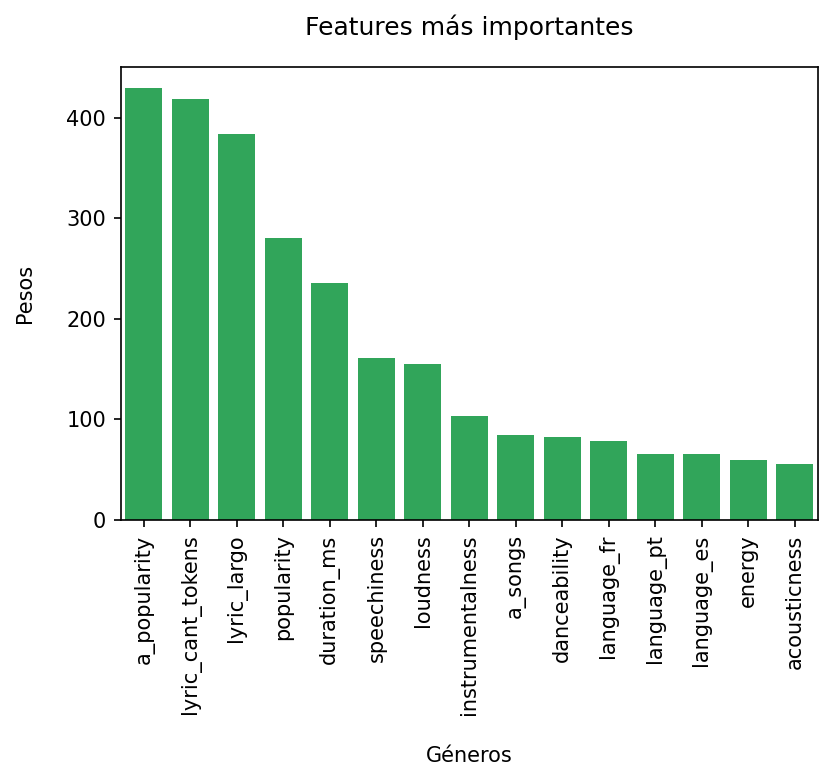

In [46]:
plt.figure(dpi=150)
sns.barplot(data=features_importantes, x="features", y="pesos", color="#1DB954")
plt.xticks(rotation=90)
plt.xlabel("Géneros", labelpad=15)
plt.ylabel("Pesos", labelpad=15)
plt.title("Features más importantes", pad=15)